In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

%matplotlib inline
import matplotlib.pyplot as plt
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import ACP_data, AdaptiveCP, ACP_plots

In [2]:
simple_data = ACP_data.stock_data(10)
var_data = ACP_data.xvy_from_ACP(simple_data, 100)

In [3]:
indi_var_data = var_data[0]

In [4]:
lookback = 50
target_alpha = 0.1

In [9]:
class new_pinball(AdaptiveCP):
    def DtACI(self, timeseries_data: tuple, gamma_candidates: np.array = None, custom_interval: int = None, title: str = None, startpoint: int = None) -> dict:
            ''' Implementation of the Dynamic Adaptive Conformal Prediction method, also commonly know as FACI'''
            xpred, y = timeseries_data
            if gamma_candidates is None:
                gamma_candidates = np.array([0.001, 0.004, 0.032, 0.064, 0.128, 0.256, 0.512])

            if startpoint is None:
                if custom_interval is not None:
                    startpoint = max(custom_interval, self.interval_size) + 1
                else:
                    startpoint = self.interval_size + 1

            # we need a vectorised version of l
            l_vec = self.vectorize_l()
            
            candiate_alpha = np.array([[self.coverage_target for _ in gamma_candidates]])
            gamma_weights = np.array([1 for _ in gamma_candidates])
            
            chosen_gamma_index = []
            err_t_list = []
            conformal_sets_list = []
            alpha_t_list = []
            alpha_error_list = []
            B_t_list = []
            
            sigma = 1/(2*self.interval_size)
            nu = np.sqrt((3/self.interval_size) * (np.log(len(gamma_candidates)*self.interval_size) + 2)/((1-self.coverage_target)**2 * self.coverage_target**2))
        
            # Calculating the scores at each time step
            All_scores = self.score_function(xpred, y)

            for i in range(startpoint, len(All_scores)):
                # Calcualting the probability of each gamma from the weights from step t-1.
                Wt = gamma_weights.sum()
                gamma_probabilites = gamma_weights/Wt
                
                # Choosing a alpha from the probabilites from the gamma candidates.
                chosen_alpha_t = np.random.choice(candiate_alpha[-1], p=gamma_probabilites)
                alpha_t_list.append(chosen_alpha_t)
                candiate_alpha_index = np.where(candiate_alpha[-1] == chosen_alpha_t)[0][0]
                chosen_gamma_index.append(candiate_alpha_index)

                Coverage_t = self.C_t(chosen_alpha_t, All_scores, xpred[i], i, custom_interval)
                conformal_sets_list.append(Coverage_t)
                
                err_true = AdaptiveCP.err_t(y[i], Coverage_t)
                err_t_list.append(err_true)

                # TIME FRONTIER -------

                # Smallest interval containg the true value. Found using binary search.
                low, high = 0, 999 
                possibilities = np.linspace(0, 1, 1000) # as 1 - 

                B_t = 1
                while low <= high:
                    mid = (high + low) // 2
                    possi = possibilities[mid]
                    Cpossi = self.C_t(possi, All_scores, xpred[i], i, custom_interval)

                    if Cpossi[0] < y[i] < Cpossi[1]:
                        B_t = possi
                        low = mid + 1
                    else:
                        high = mid - 1
                
                B_t_list.append(B_t)
                
                # Updating the weights.
                # We will change this to update the weights based off of the quantile of the error.
                candiate_alpha_widths = np.array([np.quantile(All_scores[i-self.interval_size:i], 1 - alpha) for alpha in candiate_alpha[-1]])
                B_t_width = np.quantile(All_scores[i-self.interval_size:i], 1 - B_t)

                print(candiate_alpha_widths, B_t_width)

                new_weights = gamma_weights * np.exp(-nu * l_vec(B_t_width, candiate_alpha_widths))
                
                sumW, lenW = sum(new_weights), len(new_weights)
                final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
                gamma_weights = final_weights

                # Calculating the coverage and error at each time step, for different alpha values.
                alphai_errors = np.array([AdaptiveCP.err_t(y[i], self.C_t(alpha_i, All_scores, xpred[i], i)) for alpha_i in candiate_alpha[-1]])
                alpha_error_list.append(alphai_errors)

                # Updating the alpha values.
                new_alphas = candiate_alpha[-1] + (gamma_candidates * (self.coverage_target - alphai_errors))
                candiate_alpha = np.vstack((candiate_alpha, new_alphas))

            # Calculating different averages
            realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(self.interval_size).mean().mean()
            average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

            return {
                'model': title if title is not None else 'DtACI',
                'coverage_target': self.coverage_target,
                'gamma_candidates': gamma_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'alpha_t_list': alpha_t_list,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'alpha_error_list': alpha_error_list,
                'B_t_list': B_t_list,
                'interval_size': self.interval_size ,
            }
        
 

In [10]:
w = new_pinball(0.1, 50)
result = w.DtACI(simple_data[0])


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

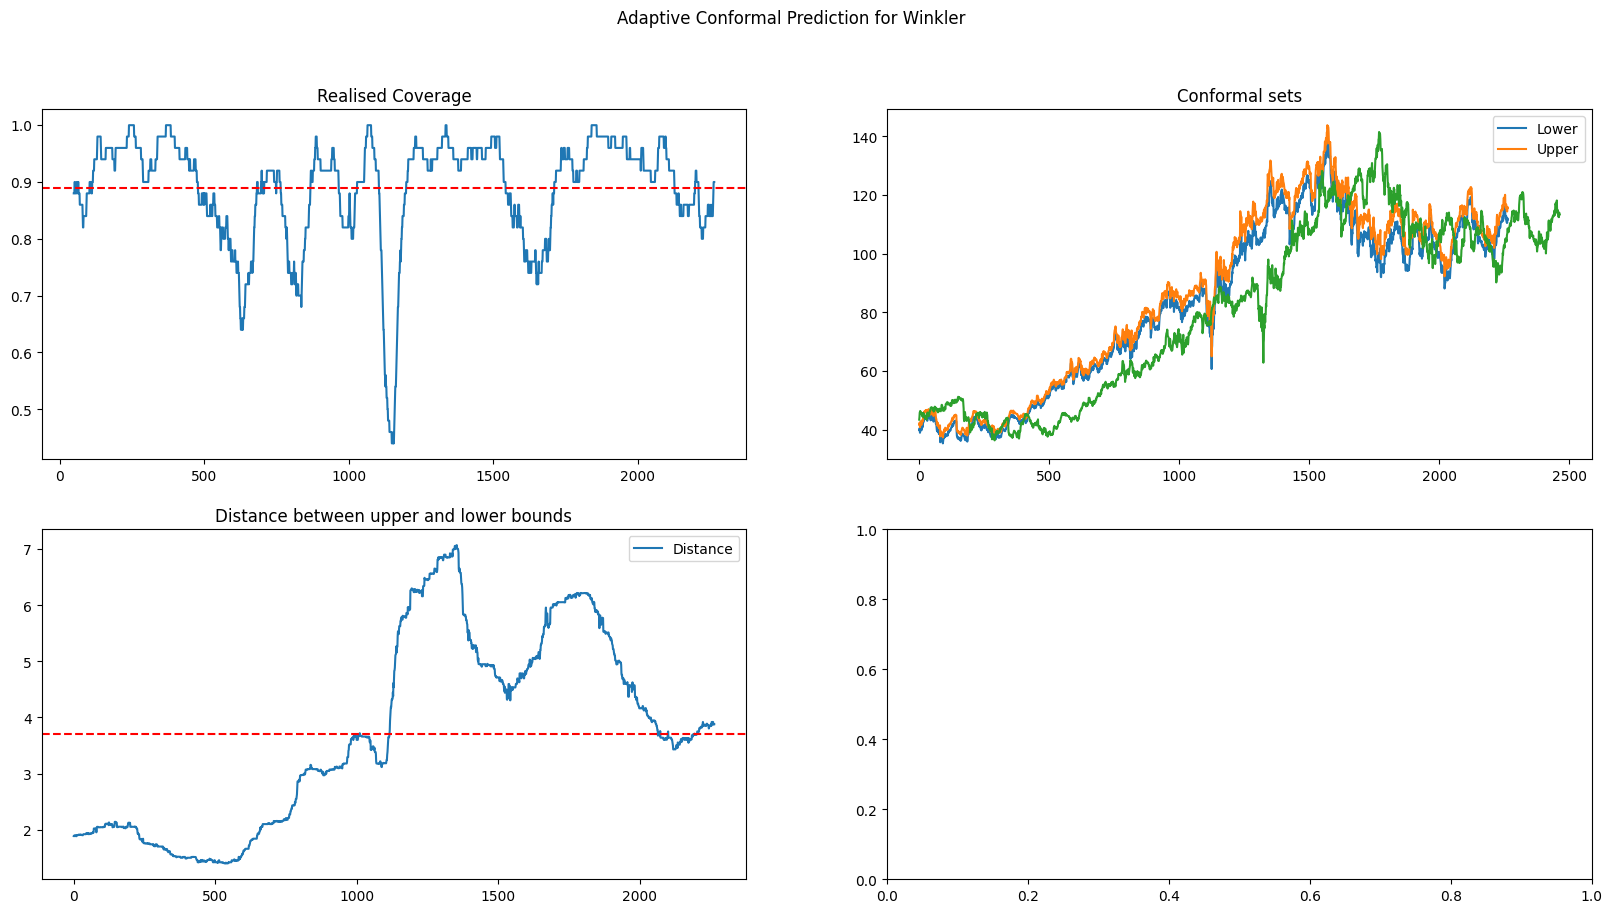

In [ ]:
ACP_plots.one_plot(result, simple_data[1])

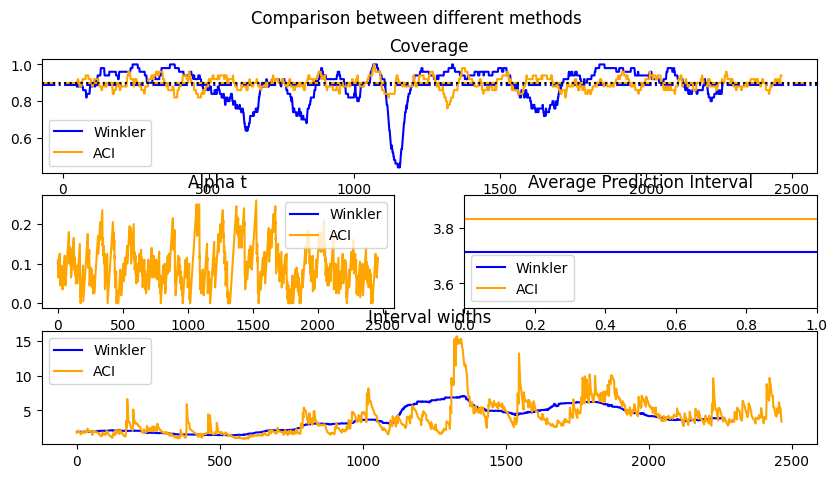

In [ ]:
ACP_plots.compare_many([result, aci_result])

In [ ]:
## Lets compare which has less winkler loss.

def winkler_loss_from_results(results, data, lookback):
    conformal_sets = results['conformal_sets']
    y = data[1][lookback+1:]

    total_loss = 0
    for set, true_y in zip(conformal_sets, y):
        total_loss+=winkler_loss_component(set[0], set[1], true_y, results['coverage_target'])
    return total_loss

In [ ]:
print(winkler_loss_from_results(result, simple_data, 50))
print(winkler_loss_from_results(aci_result, simple_data, 50))

432309.6969478908
13202.11764697414


In [ ]:
result_list = []
raw_result_list = []
for lookback in range(10, 500, 100):
    result = w.SimpleWinklerMethod(simple_data, lookback, 501)
    result_list.append(winkler_loss_from_results(result, simple_data, lookback))
    raw_result_list.append(result)

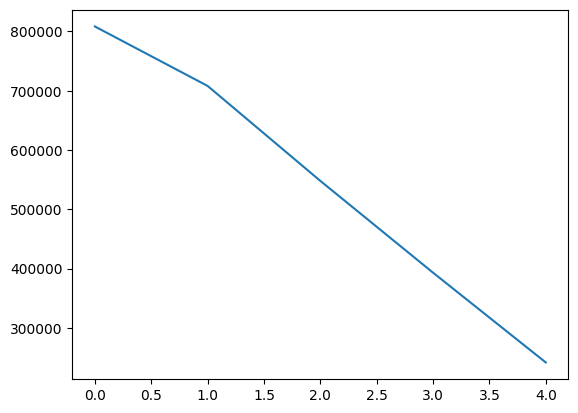

In [ ]:
plt.plot(result_list)

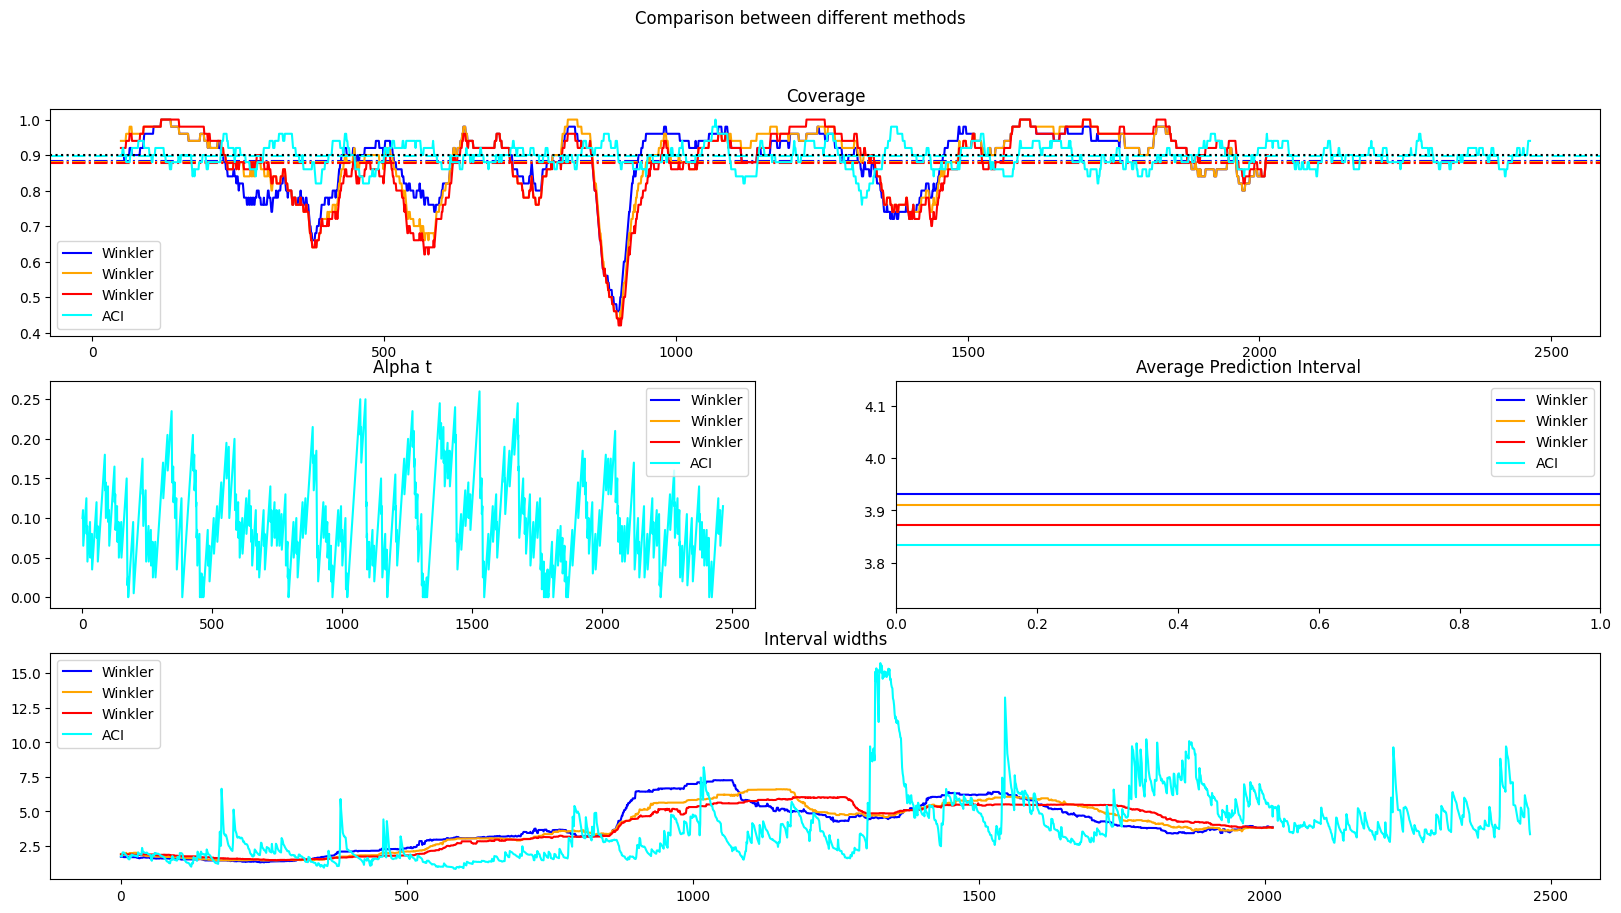

In [ ]:
ACP_plots.compare_many(raw_result_list[-3:] + [aci_result], (20, 10))

In [ ]:
print(np.mean([x['realised_interval_coverage'] for x in raw_result_list[-8:]]))

0.8831597151576804
